# <center>Reduciendo inconformidad en los grupos de la carrera de actuaría.
</center>

### **Descripción del problema:**
Se ha realizado la encuesta para la elección de materias de los alumnos de la carrera de actuaría y capturado los datos en una hoja de cálculo. Todos los semestres se presentan quejas por la forma en que los grupos son formados así que se requiere hacer una agrupación de tal manera que la mayor cantidad de alumnos pueda estar en las materias de su preferencia.
Por cuestiones de personal y económicas, se ha limitado la cantidad de grupos a 5 con 5 materias por grupo, y se busca que la cantidad de alumnos se distribuya de manera equitativa entre estos grupos.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import modules for clustering
from sklearn.cluster import KMeans
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

from warnings import filterwarnings
filterwarnings('ignore')


In [4]:
# Path for google colab
# from google.colab import drive
# drive.mount('/content/drive')
# Path for local execution
#Import for google colab, installing modules if needed
# !pip install pandas
# !pip install sklearn
# !pip install matplotlib
# !pip install scipy

Carga y preparación inicial de los datos

In [3]:
file = pd.ExcelFile("Grupos_Optativas.xlsx")
df = file.parse('Base completa de eleccion')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Individuo             609 non-null    int64  
 1   Orden de preferencia  609 non-null    int64  
 2   Clave                 608 non-null    float64
 3   Nombre de la Materia  599 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 19.2+ KB


Breve exploración de los datos

Removemos la columna 'nombre de la materia' ya que esta presenta múltiples errores de captura y no aporta información relevante para el análisis, a su vez, se elimina, los registros nulos de la columna 'clave'

In [4]:
df = df.drop(columns=["Nombre de la Materia"])
df = df.dropna(subset=['Clave'])
df["Clave"] = df["Clave"].astype(int)

#Modificar el valor de aquellos elementos que tengan la clave 2511 por 2037
df.loc[df['Clave'] == 2511, 'Clave'] = 2037

df=df.sort_values(by=["Individuo",'Orden de preferencia'])
df.reset_index(drop=True, inplace=True)



Formamos un nuevo dataset que tenga la información de los alumnos como vector y al alumno como su indice

In [5]:
new_cols= []
new_cols.append("Individuo")
new_cols.extend(sorted([str(clave) for clave in df["Clave"].unique()]))
clustering_df = pd.DataFrame(columns=new_cols)

In [20]:
keys = clustering_df.columns

for group in df.groupby("Individuo"):
  
  storage_dict = {columna: 0 for columna in keys}
  storage_dict["Individuo"] = group[0]
  
  for row in group[1].iterrows():
    storage_dict[str(row[1]["Clave"])] = row[1]["Orden de preferencia"]
  
  #clustering_df = clustering_df.append(storage_dict, ignore_index=True)
  #Perform the previous line in the most recent version of pandas
  clustering_df = pd.concat([clustering_df, pd.DataFrame.from_records([storage_dict])], ignore_index=True)
clustering_df
  

,Individuo,2030,2031,2032,2033,2034,2035,2036,2037,2038,...,2048,2049,2050,2051,2053,2054,2055,2056,2612,2613
0,1,5,4,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,5,3,0,0,...,0,0,0,0,0,0,0,4,0,0
2,3,0,0,0,0,5,0,0,0,0,...,0,2,0,3,0,0,0,0,0,0
3,4,0,0,0,3,0,5,0,0,0,...,0,2,0,0,0,1,0,0,0,0
4,5,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,120,0,4,5,2,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
120,121,0,2,4,0,3,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
121,122,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
122,123,0,4,3,5,0,0,0,0,0,...,2,1,0,0,0,0,0,0,0,0


Formamos un dataframe extra para hacer estadística descriptiva sobre los datos 

In [21]:
df['Frecuencia'] = df.groupby('Clave')['Clave'].transform('count')
df['Interes'] = df.groupby('Clave')['Orden de preferencia'].transform('sum')
#Adding the mean and the sum of the preference order for each subject
temp_df = df.groupby('Clave').agg({'Orden de preferencia':['mean','sum'], 'Frecuencia':'first'})
temp_df.columns = ['_'.join(col) for col in temp_df.columns.values]

del df

In [22]:
#Correlation analysis between the interest and the frequency with the pearson method
pearson_coef, p_value = stats.pearsonr(temp_df["Orden de preferencia_sum"], temp_df["Frecuencia_first"])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)


The Pearson Correlation Coefficient is 0.9906466226833289  with a P-value of P = 5.053357925839513e-24


Al hacer las medidas para la suma del interes y la frecuencia se vió que tenían un comportamiento similar,
con esto se observó que ambas variables están correlacionadas, por lo que se puede usar cualquiera de las dos
y se eligió la suma del interes por materia.

In [23]:
# Show the statistics of the frequency values
data = temp_df["Orden de preferencia_sum"]
summary = pd.Series({
    'count': len(data),
    'mean': np.mean(data),
    'std': np.std(data),
    'min': np.min(data),
    '25%': np.percentile(data, 25),
    '50%': np.percentile(data, 50),
    '75%': np.percentile(data, 75),
    'max': np.max(data),
})
print(summary)
condition = data >= np.percentile(data, 25)
count = np.count_nonzero(condition)
print(f'The number of courses with frequency greater than the 25% is: {count}')
#Get the list of the subjects with frequency greater than the 25%

count     28.000000
mean      65.714286
std       73.848715
min        3.000000
25%       10.000000
50%       30.500000
75%      107.750000
max      287.000000
dtype: float64
The number of courses with frequency greater than the 25% is: 22


Generamos un histograma del interés en las materias y establecemos una línea de aquellos que están por debajo del percentel del 25 por ciento para ignorar estos posteriormente

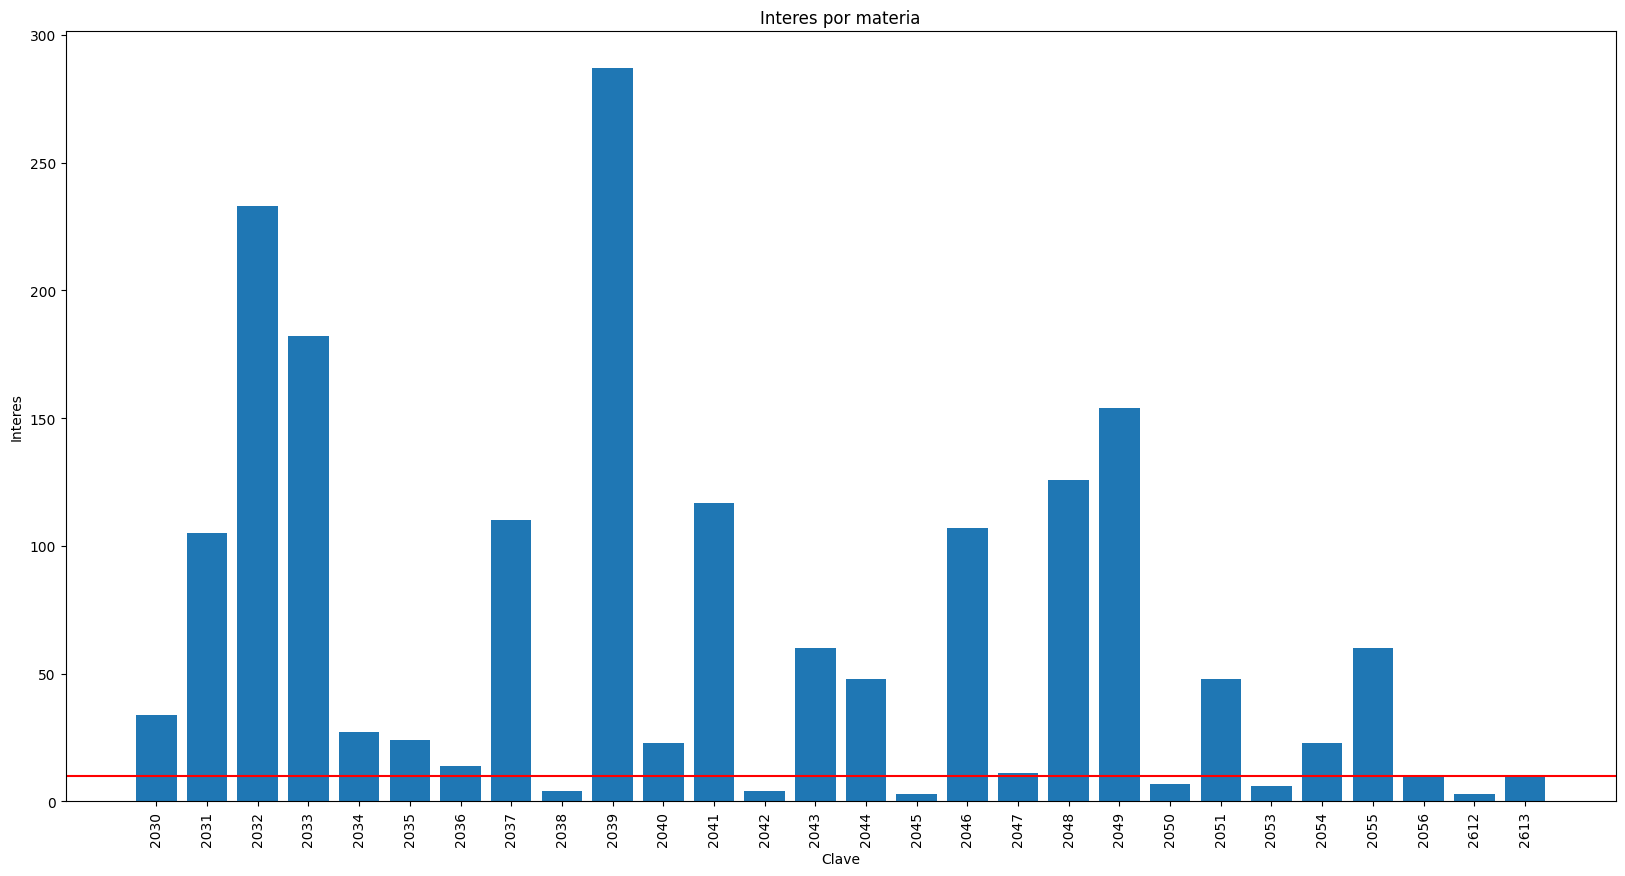

In [24]:
#Plot a histogram with the x axis the key and the y axis the interest
plt.figure(figsize=(20,10))
plt.bar(temp_df.index.astype(str), temp_df["Orden de preferencia_sum"])
plt.xticks(rotation=90)
plt.title("Interes por materia")
plt.xlabel("Clave")
plt.ylabel("Interes")
#Add a line at the y axis at value 10
plt.axhline(y=np.percentile(data, 25), color='r', linestyle='-')
plt.show()

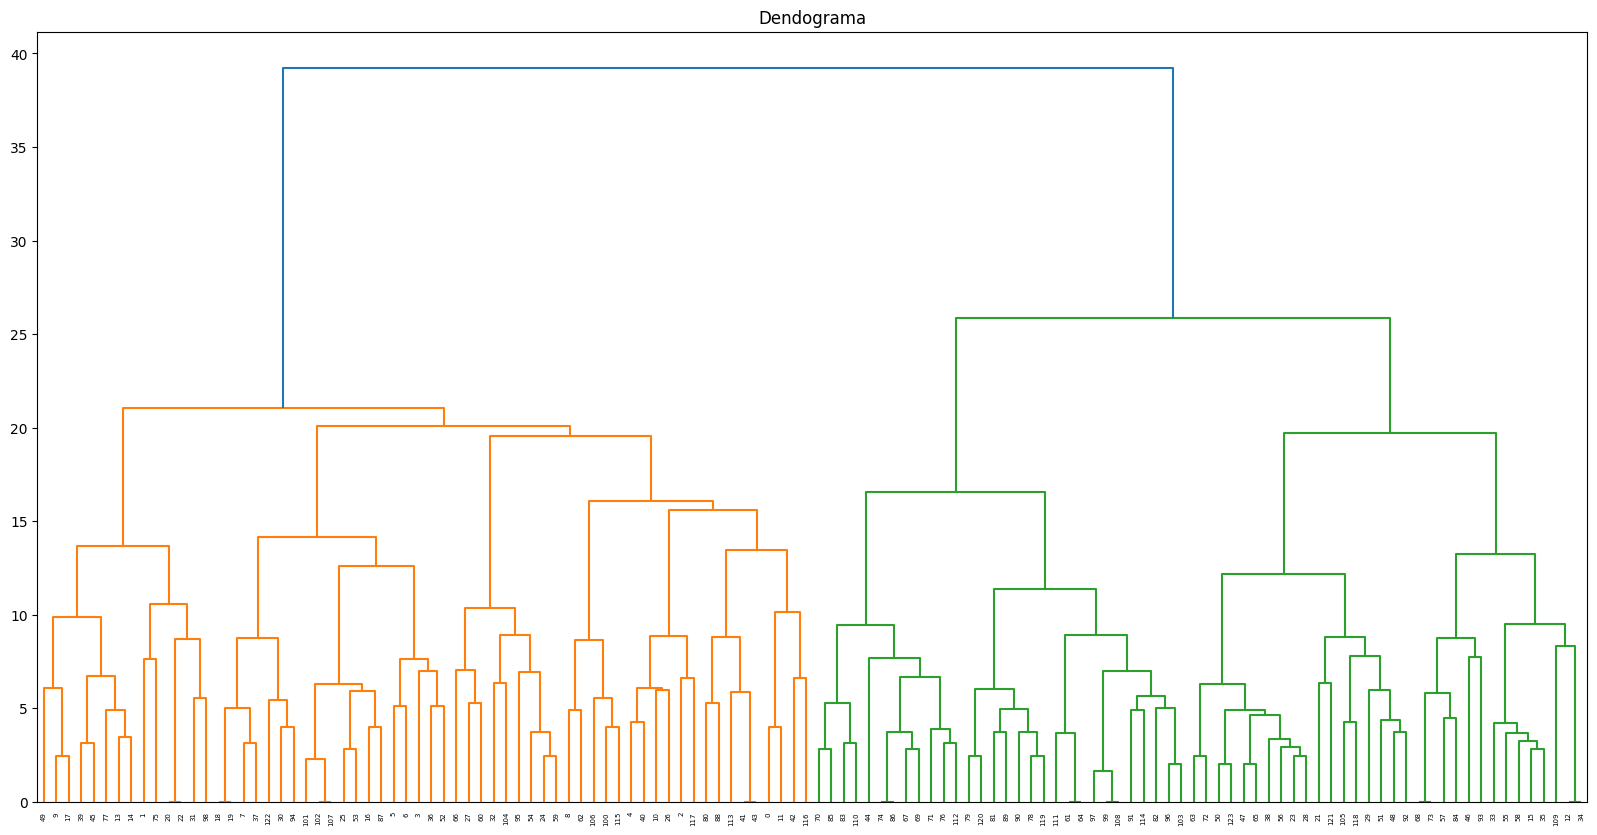

In [25]:
#Create a dendogram with the clustering_df dataframe
plt.figure(figsize=(20,10))
plt.title("Dendograma")
dendrogram(linkage(clustering_df.iloc[:,1:], method='ward'))
plt.show()


In [26]:
# Get the list of the subjects with frequency greater than the 25%
list_of_subjects = temp_df.index[condition].tolist()
list_of_subjects = [str(subject) for subject in list_of_subjects]
# list_of_subjects.insert(0,"Individuo")
#Remove the columns that don't match the condition of interest
clustering_df = clustering_df[list_of_subjects]
                       

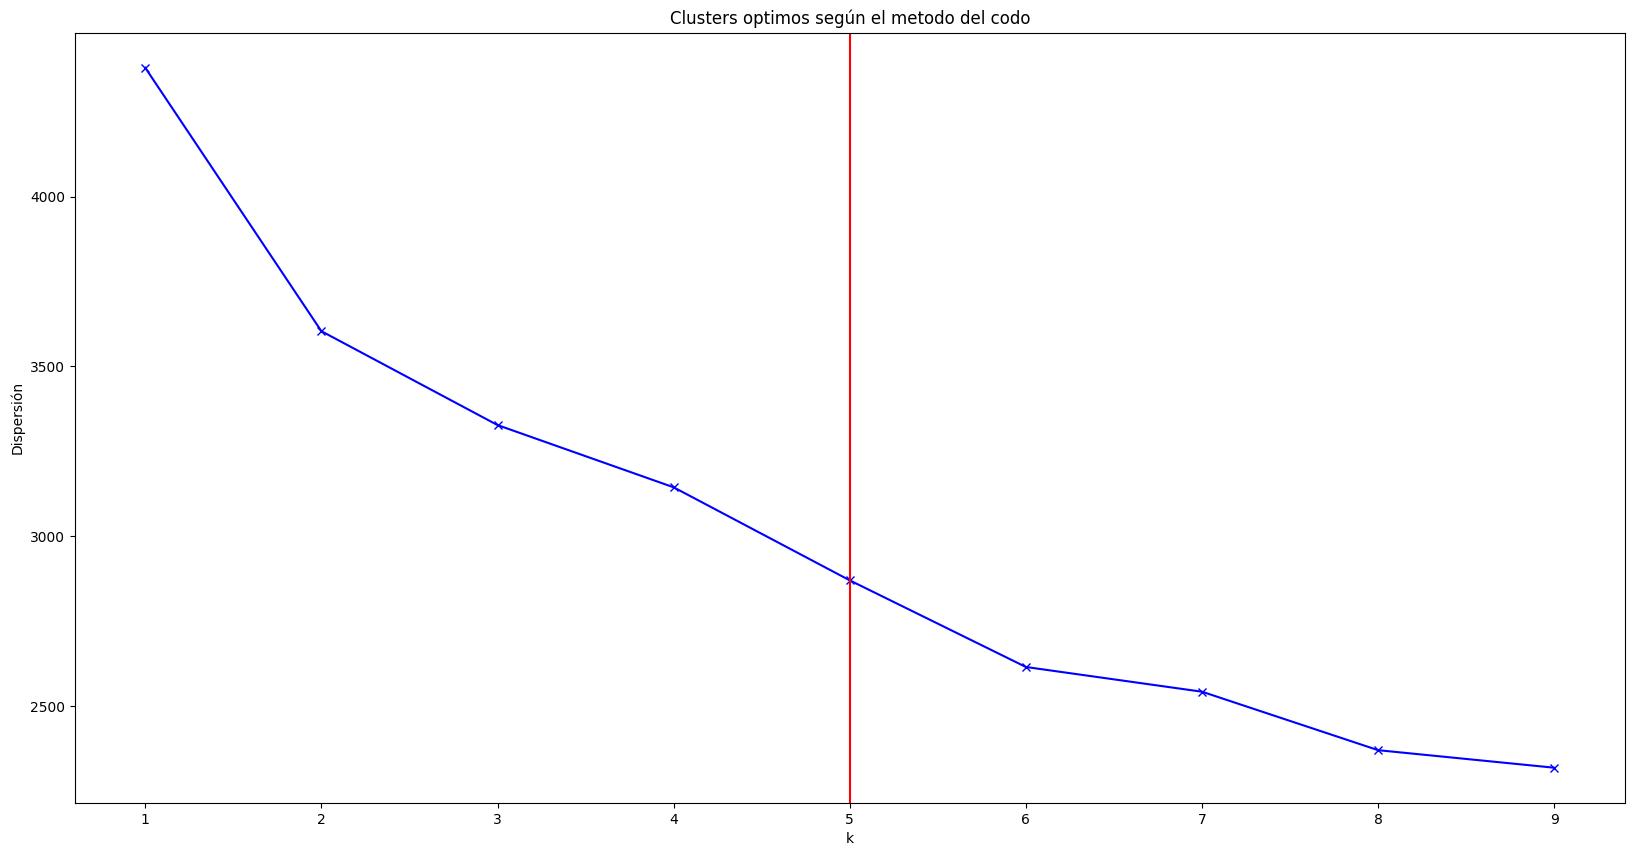

In [27]:
#Applying the elbow method to find the optimal number of clusters
to_cluster = clustering_df.iloc[:, 1:]
dispersiones = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(to_cluster)
    dispersiones.append(kmeanModel.inertia_)
plt.figure(figsize=(20,10))
plt.plot(K, dispersiones, 'bx-')
plt.xlabel('k')
plt.ylabel('Dispersión')
plt.title('Clusters optimos según el metodo del codo')
#Add a line at the x axis at value 5
plt.axvline(x=5, color='r', linestyle='-')
plt.show()

In [28]:
clusters = 5
kmeans = KMeans(n_clusters=clusters, random_state=0)
clustering_df['Cluster'] = kmeans.fit_predict(to_cluster)
#Print the number of elements in each cluster
print(clustering_df['Cluster'].value_counts())

Cluster
1    33
4    29
2    26
3    18
0    18
Name: count, dtype: int64


In [53]:
#Plotting the data points with the color of the cluster they belong to
# plt.figure(figsize=(30,15))
# plt.scatter(clustering_df['Individuo'], clustering_df['Cluster'], c=clustering_df['Cluster'], s=50, cmap='viridis')
# plt.title("Clusters")
# plt.xlabel("Individuo")
# plt.ylabel("Cluster")
# plt.show()


In [29]:
#Generate a dictionary with the subject key and their centroid for each cluster
clusters_dict = {}
for cluster in range(clusters):
  clusters_dict[cluster] = {}
  for key in clustering_df.columns[1:-1]:
    clusters_dict[cluster][key] = clustering_df[clustering_df["Cluster"] == cluster][key].mean()

In [30]:
#Get the 5 subjects with the highest interest for each cluster
top_5_interest = {}
for cluster in clusters_dict:
  top_5_interest[cluster] = sorted(clusters_dict[cluster].items(), key=lambda x: x[1], reverse=True)[:5]


In [31]:
col_names = ['Materia', "Clave"]
keys_df = pd.read_excel("Grupos_Optativas.xlsx", sheet_name="materias", usecols="A:B", names=col_names,nrows=27, header=None)

In [32]:
#Generate a dictionary with the cluster and the top 5 subjects with the highest interest
grupos = {}
for grupo in clustering_df["Cluster"].unique():
  grupos[grupo] = []
  for materia in top_5_interest[grupo]:
    grupos[grupo].append(keys_df[keys_df["Clave"] == int(materia[0])]["Materia"].values[0])

In [33]:
#Print the groups ordered by the cluster
for grupo in sorted(grupos):
  print(f"Grupo {grupo}: {grupos[grupo]}")

Grupo 0: ['Evaluación de Proyectos', 'Investigación de Operaciones II', 'Muestreo', 'Modelos y simulación', 'Planeación financiera']
Grupo 1: ['Análisis de Regresión', 'Modelos y simulación', 'Investigación de Operaciones II', 'Análisis Multivariado', 'Muestreo']
Grupo 2: ['Estadística Bayesiana', 'Modelos y simulación', 'Análisis de Regresión', 'Muestreo', 'Análisis Multivariado']
Grupo 3: ['Modelos y simulación', 'Derivados', 'Análisis de estados financieros', 'Planeación financiera', 'Evaluación de Proyectos']
Grupo 4: ['Derivados', 'Auditoria Actuarial', 'Análisis Multivariado', 'Evaluación de Proyectos', 'Finanzas Pùblicas']


In [59]:
cols_from_cluster_to_export= ["Cluster", "Individuo"]
indixes_plus_1 = [str(i+1) for i in clustering_df.index]
clustering_df['Individuo'] = indixes_plus_1
grupos_df = pd.DataFrame(grupos)
grupos_df = grupos_df.transpose()
grupos_df.columns = ["Materia 1", "Materia 2", "Materia 3", "Materia 4", "Materia 5"]
grupos_df.reset_index(inplace=True)
grupos_df.rename(columns={"index":"Grupo"}, inplace=True)
grupos_df.sort_values(by=["Grupo"], inplace=True)
# Export the dataframes to excel
with pd.ExcelWriter('Analisis_optativas.xlsx', engine='openpyxl', mode='w') as writer:  
    clustering_df[cols_from_cluster_to_export].to_excel(writer, sheet_name='Base completa de eleccion', index=False)
    grupos_df.to_excel(writer, sheet_name='Grupos', index=False)

In [7]:
groups_df = pd.read_excel("Analisis_optativas.xlsx", sheet_name="Grupos")
students_df = pd.read_excel("Analisis_optativas.xlsx", sheet_name="Base completa de eleccion")

students_df

,Cluster,Individuo
0,3,1
1,3,2
2,3,3
3,3,4
4,3,5
...,...,...
119,4,120
120,4,121
121,2,122
122,0,123


In [54]:
groups_df

,Grupo,Materia 1,Materia 2,Materia 3,Materia 4,Materia 5
0,0,Derivados,Evaluación de Proyectos,Auditoria Actuarial,Análisis Multivariado,Modelos y simulación
1,1,Investigación de Operaciones II,Análisis de Regresión,Modelos y simulación,Muestreo,Evaluación de Proyectos
2,2,Estadística Bayesiana,Muestreo,Modelos y simulación,Análisis de Regresión,Series de Tiempo
3,3,Auditoria Actuarial,Modelos y simulación,Planeación financiera,Evaluación de Proyectos,Análisis de estados financieros
4,4,Análisis de Regresión,Modelos y simulación,Análisis Multivariado,Derivados,Series de Tiempo


In [8]:
students_df.columns = ["Grupo", "Individuo"]
students_df.merge(groups_df, on="Grupo", how="inner")

,Grupo,Individuo,Materia 1,Materia 2,Materia 3,Materia 4,Materia 5
0,3,1,Auditoria Actuarial,Modelos y simulación,Planeación financiera,Evaluación de Proyectos,Análisis de estados financieros
1,3,2,Auditoria Actuarial,Modelos y simulación,Planeación financiera,Evaluación de Proyectos,Análisis de estados financieros
2,3,3,Auditoria Actuarial,Modelos y simulación,Planeación financiera,Evaluación de Proyectos,Análisis de estados financieros
3,3,4,Auditoria Actuarial,Modelos y simulación,Planeación financiera,Evaluación de Proyectos,Análisis de estados financieros
4,3,5,Auditoria Actuarial,Modelos y simulación,Planeación financiera,Evaluación de Proyectos,Análisis de estados financieros
...,...,...,...,...,...,...,...
119,4,120,Análisis de Regresión,Modelos y simulación,Análisis Multivariado,Derivados,Series de Tiempo
120,4,121,Análisis de Regresión,Modelos y simulación,Análisis Multivariado,Derivados,Series de Tiempo
121,2,122,Estadística Bayesiana,Muestreo,Modelos y simulación,Análisis de Regresión,Series de Tiempo
122,0,123,Derivados,Evaluación de Proyectos,Auditoria Actuarial,Análisis Multivariado,Modelos y simulación


In [16]:
materias = file.parse('materias',header=None)
materias = materias[[0,1]]
materias.columns = ["Clave", "Materia"]
materias

,Clave,Materia
0,Derivados,2033.0
1,Modelos y simulación,2039.0
2,Estadística Bayesiana,2048.0
3,Evaluación de Proyectos,2049.0
4,Auditoria Actuarial,2046.0
5,Muestreo,2041.0
6,Análisis de Regresión,2032.0
7,Análisis Multivariado,2031.0
8,Investigación de Operaciones II,2037.0
9,Planeación financiera,2043.0
